In [ ]:
IN_COLAB = 'google.colab' in str(get_ipython())
if IN_COLAB:
  !pip install git+https://github.com/pete88b/nbdev_colab_helper.git
  from nbdev_colab_helper.core import *
  project_name = 'nextai'
  init_notebook(project_name)

In [ ]:
# default_exp core

# 01_anchor_boxes

> Generate anchor boxes according to pre_set parameters.

In [ ]:
#hide
from nbdev.showdoc import *
from nbdev import *

In [ ]:
#export
from fastai.torch_core import *
import numpy as np

In [ ]:
#hide
# Set up online plotting
%matplotlib inline
import matplotlib.pyplot as plt

#### Anchor Boxes
This method creates anchor boxes of various sizes on top of a grid with coordinates of size (-1,-1) top-left and (1,1)  bottom-right.<br><br>
Preset Parameters:

*   anc_grids  -  Preset anchor sizes: 4 x 4, 2 x 2, 1 x 1
*   anc_zooms  -  Preset anchor zooming coefficients: (0.75, 1, 1.3)
*   anc_ratios -  Preset anchor size ratios:  (1., 1.), (1., 0.5), (0.5, 1.)
<br>

Outputs:<br>
*   k         -   Number of default boxes associated to a give image. This parameter is used by the SSD model 
*   anchors   -   Array of anchor boxes to be used in training and inference.<br>              Tensor of dimension (m, 4), where m = k x 21







In [ ]:
#export
#### Anchor Boxes
# This methods creates anchor boxes based on a grid with coordinates  (-1,-1), (1,1), top-left, bottom-right.
def get_anchors():
    '''
    This method creates anchor boxes of various sizes on top of a grid with coordinates of size (-1,-1) top-left and (1,1) bottom-right.

    Preset Parameters:
    anc_grids - Preset anchor sizes: 4 x 4, 2 x 2, 1 x 1
    anc_zooms - Preset anchor zooming coefficients: (0.75, 1, 1.3)
    anc_ratios - Preset anchor size ratios: (1., 1.), (1., 0.5), (0.5, 1.)

    Outputs:
    k - Number of default boxes associated to a give image. This parameter is used by the SSD model
    anchors - Array of anchor boxes to be used in training and inference.
              Tensor of dimension (m, 4), where m = k x 21
    '''
    anc_grids = [4, 2, 1]                           # Anchor grid side elements ( 4x4, 2x2, 1x1)
    anc_zooms = [0.75, 1., 1.3]                     # Anchor zooming coefficients
    anc_ratios = [(1., 1.), (1., 0.5), (0.5, 1.)]   # Anchor aspect rations

    anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]

    # *** Number of default boxes (9) associated to a given image ***
    k = len(anchor_scales)     # To be used in the SSD model
    # **********************************************

    # Compute the offsets-to-the-center for each of the grid sizes
    anc_offsets = [2/(o*2) for o in anc_grids] 

    # Compute x-ccordinates for center points
    anc_x = np.concatenate([np.repeat(np.linspace(ao-1, 1-ao, ag), ag)
                            for ao, ag in zip(anc_offsets,anc_grids)])

    # Compute  y_coordinates for center points
    anc_y = np.concatenate([np.tile(np.linspace(ao-1, 1-ao, ag), ag)
                            for ao, ag in zip(anc_offsets,anc_grids)])

    # Compile list of center coordinates
    anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

    # List of height (h) and width (w) for each anchor box
    anc_sizes = np.concatenate([np.array([[2*o/ag,2*p/ag] 
                  for i in range(ag*ag) for o,p in anchor_scales])
                    for ag in anc_grids]) 

    # List of height (h) and width (w) for each grid cell
    grid_sizes = tensor(np.concatenate([np.array([ 1/ag 
                  for i in range(ag*ag) for o,p in anchor_scales])
                      for ag in anc_grids])).unsqueeze(1) * 2 

    # List of anchors in format 'center xy, height, width'                
    anchors = tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1)).float()

    # List of anchor box corner coordinates. Top-left & bottom-right
    # TODO: resolve anchor_corners
    #anchor_cnr = cthw2corners(anchors)

    return anchors

In [ ]:
#hide
anchors = get_anchors()

In [ ]:
#export
# Display generated anchor grid
def show_anchors(ancs, size, y_first=True):
    _,ax = plt.subplots(1,1, figsize=(7,7))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid(True, which='both')
    ax.scatter(ancs[:,1], ancs[:,0] if y_first else ancs[:,0], ancs[:,1]) 
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))


In [ ]:
#hide
anchors.shape

torch.Size([189, 4])

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


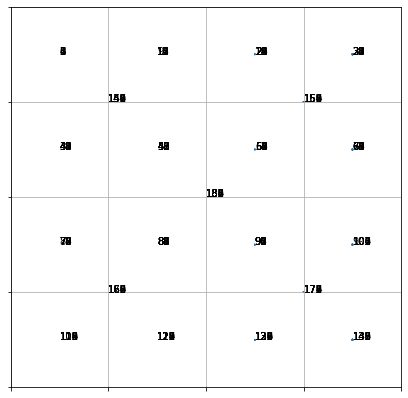

In [ ]:
#hide
show_anchors(anchors,(4,4), y_first=True)

In [ ]:
#hide
anchors

tensor([[-0.7500, -0.7500,  0.3750,  0.3750],
        [-0.7500, -0.7500,  0.3750,  0.1875],
        [-0.7500, -0.7500,  0.1875,  0.3750],
        [-0.7500, -0.7500,  0.5000,  0.5000],
        [-0.7500, -0.7500,  0.5000,  0.2500],
        [-0.7500, -0.7500,  0.2500,  0.5000],
        [-0.7500, -0.7500,  0.6500,  0.6500],
        [-0.7500, -0.7500,  0.6500,  0.3250],
        [-0.7500, -0.7500,  0.3250,  0.6500],
        [-0.7500, -0.2500,  0.3750,  0.3750],
        [-0.7500, -0.2500,  0.3750,  0.1875],
        [-0.7500, -0.2500,  0.1875,  0.3750],
        [-0.7500, -0.2500,  0.5000,  0.5000],
        [-0.7500, -0.2500,  0.5000,  0.2500],
        [-0.7500, -0.2500,  0.2500,  0.5000],
        [-0.7500, -0.2500,  0.6500,  0.6500],
        [-0.7500, -0.2500,  0.6500,  0.3250],
        [-0.7500, -0.2500,  0.3250,  0.6500],
        [-0.7500,  0.2500,  0.3750,  0.3750],
        [-0.7500,  0.2500,  0.3750,  0.1875],
        [-0.7500,  0.2500,  0.1875,  0.3750],
        [-0.7500,  0.2500,  0.5000

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 00_inference_core.ipynb.
Converted 01_anchor_boxes.ipynb.
Converted index.ipynb.
